In [1]:
import sys
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

sys.path.insert(0, '../CODE/')
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys2com_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

# Cross-TF validation of yeast cells using TF binding data from Transposon Calling Cards

In [3]:
organism = 'yeast'
output_dir = '../OUTPUT/yeast_cc/all_feats/'

pred_df = pd.read_csv(output_dir + 'preds.csv.gz')

rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
stats_df = stats_df.merge(rr_df, on='tf')

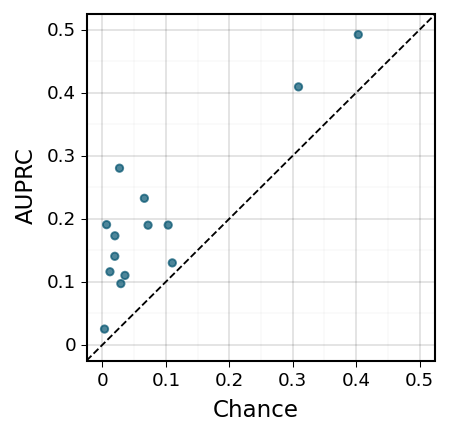

<ggplot: (-9223370582990114756)>

In [4]:
ax = (
    ggplot(stats_df, aes(x='label', y='auprc'))
    + geom_point(color=COLORS['dark_blue'], alpha=.7)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + lims(x=[0, .5], y=[0, .5])
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

display(ax)

ax.save('figures/Yeast_CallingCards_auprc_v_chance.pdf')

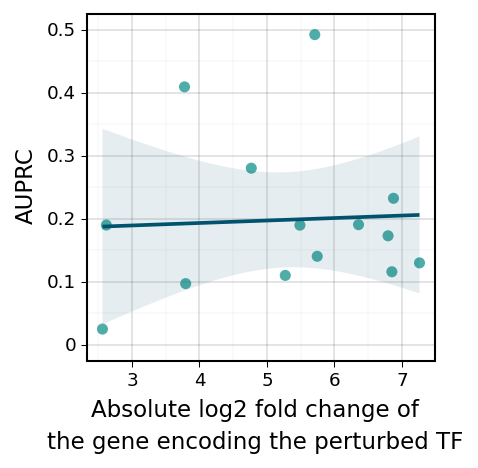

<ggplot: (-9223370582990708841)>

In [5]:
pert_df = pd.read_csv('../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv', index_col=0)

pert_fc = pd.DataFrame()

for tf in sorted(stats_df['tf'].unique()):
    row = pd.Series({
        'tf': tf,
        'lfc': pert_df[tf].loc[tf]
    })
    pert_fc = pert_fc.append(row, ignore_index=True)
    
plot_df = stats_df.merge(pert_fc, how='left', on='tf')
plot_df['absLFC'] = np.abs(plot_df['lfc'])

ax = (
    ggplot(plot_df, aes(x='absLFC', y='auprc'))
    + geom_point(alpha=.7, size=3, stroke=0, color=COLORS['dark_green'])
    + geom_smooth(method='lm', color=COLORS['dark_blue'], fill=COLORS['dark_blue'], alpha=.1)
    + labs(x='Absolute log2 fold change of\nthe gene encoding the perturbed TF', y='AUPRC')
    + lims(y=[0, .5])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150,
        axis_title=element_text(lineheight=1.5))
)

display(ax)

ax.save('figures/Yeast_CallingCards_auprc_v_tfpert_quality.pdf')

# Compare AUCs for binding potentials, ChIP-exo, and Calling Cards

In [3]:
organism = 'yeast'
data_type_dict = {
    'yeast_bp': 'Binding Potentials',
    'yeast_chipexo': 'ChIP-exo',
    'yeast_cc': 'Calling Cards'
}

comb_stats_df = pd.DataFrame()

# Get chance AUC
pred_df = pd.read_csv('../OUTPUT/yeast_bp/all_feats/preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()
rr_df = rr_df.rename(columns={'label': 'auprc'})
rr_df['data_type'] = 'Theoratical Chance'
comb_stats_df = comb_stats_df.append(rr_df, ignore_index=True)

# Get model AUC
for data_type in data_type_dict.keys():
    output_dir = '../OUTPUT/{}/all_feats/'.format(data_type)
    stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
    stats_df = stats_df.dropna()
    stats_df['data_type'] = data_type_dict[data_type]
    comb_stats_df = comb_stats_df.append(stats_df, ignore_index=False)

comb_stats_df['tf_full_name'] = comb_stats_df['tf'].apply(lambda x: '{} ({})'.format(x, sys2com_dict[x]))
                                            
# Order groups by data type
comb_stats_df['data_type'] = pd.Categorical(
    comb_stats_df['data_type'], ordered=True,
    categories=['Theoratical Chance', 'Binding Potentials', 'ChIP-exo', 'Calling Cards']
)

# Order TFs by max AUC
max_auc_df = comb_stats_df.groupby('tf_full_name')[['auprc']].max().reset_index()

comb_stats_df['tf_full_name'] = pd.Categorical(
    comb_stats_df['tf_full_name'], ordered=True,
    categories=max_auc_df.sort_values('auprc')['tf_full_name'].values
)

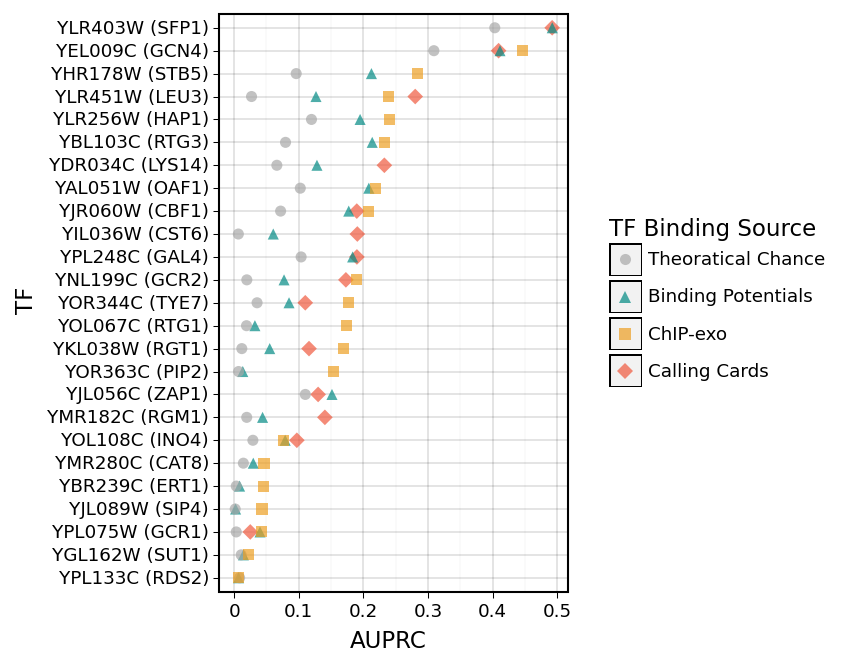

<ggplot: (-9223370635546595854)>

In [15]:
ax = (
    ggplot(comb_stats_df, aes(x='auprc', y='tf_full_name', color='data_type', shape='data_type'))
    + geom_point(alpha=.7, size=3, stroke=0)
    + scale_color_manual([COLORS['grey'], COLORS['dark_green'], COLORS['yellow'], COLORS['orange']])
    + labs(x='AUPRC', y='TF', color='TF Binding Source', shape='TF Binding Source')
    + theme_linedraw()
    + theme(figure_size=(3, 5), dpi=150)
)
display(ax)

ax.save('figures/Yeast_tf_binding_type_vs_auprc.pdf')

# Compare AUCs for binding potentials, ChIP-exo, and Calling Cards -- cross validated on the 8 common TFs

In [3]:
organism = 'yeast'
data_type_dict = {
    'yeast_bp': 'Binding Potentials',
    'yeast_chipexo': 'ChIP-exo',
    'yeast_cc': 'Calling Cards'
}

comb_stats_df = pd.DataFrame()

# Get chance AUC
pred_df = pd.read_csv('../OUTPUT/yeast_bp/all_feats_8_common_tfs/preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()
rr_df = rr_df.rename(columns={'label': 'auprc'})
rr_df['data_type'] = 'Theoratical Chance'
comb_stats_df = comb_stats_df.append(rr_df, ignore_index=True)

# Get model AUC
for data_type in data_type_dict.keys():
    output_dir = '../OUTPUT/{}/all_feats_8_common_tfs/'.format(data_type)
    stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
    stats_df = stats_df.dropna()
    stats_df['data_type'] = data_type_dict[data_type]
    comb_stats_df = comb_stats_df.append(stats_df, ignore_index=False)

comb_stats_df['tf_full_name'] = comb_stats_df['tf'].apply(lambda x: '{} ({})'.format(x, sys2com_dict[x]))
                                            
# Order groups by data type
comb_stats_df['data_type'] = pd.Categorical(
    comb_stats_df['data_type'], ordered=True,
    categories=['Theoratical Chance', 'Binding Potentials', 'ChIP-exo', 'Calling Cards']
)

# Order TFs by max AUC
max_auc_df = comb_stats_df.groupby('tf_full_name')[['auprc']].max().reset_index()

comb_stats_df['tf_full_name'] = pd.Categorical(
    comb_stats_df['tf_full_name'], ordered=True,
    categories=max_auc_df.sort_values('auprc')['tf_full_name'].values
)

0    YEL009C
1    YJR060W
2    YKL038W
3    YLR451W
4    YNL199C
5    YOL108C
6    YOR344C
7    YPL075W
Name: tf, dtype: object


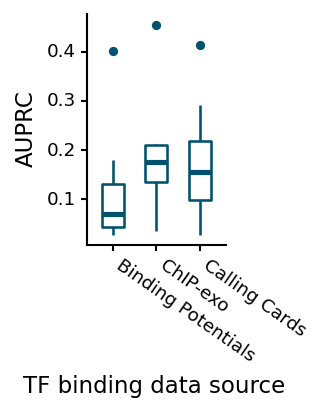

<ggplot: (-9223369074380435852)>

In [4]:
# Compare common TFs
data_cnt = comb_stats_df.groupby('tf')[['auprc']].count().reset_index()
com_tfs = data_cnt.loc[data_cnt['auprc'] == 4, 'tf']

print(com_tfs)

plot_df = comb_stats_df[comb_stats_df['tf'].isin(com_tfs)]
plot_df = plot_df[plot_df['data_type'] != 'Theoratical Chance']

ax = (
    ggplot(plot_df, aes(x='data_type', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
    + xlab('TF binding data source')
    + ylab('AUPRC')
    + theme_classic()
    + theme(figure_size=(1.2, 2), dpi=150,
           axis_text_x=element_text(color='#000000', angle=-35, hjust=0),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_tf_binding_type_vs_auprc_common_tfs.pdf')

# Net influence calculated using SHAP values

- Distribution across TFs of the “net influence” of each feature on predictions, averaged over responsive targets. 
- Net influence is the sum of all SHAP values for a feature, regardless of sign or genomic position.

In [4]:
tfs = np.loadtxt('../RESOURCES/TF_list/Yeast_CallingCards_TFs.txt', dtype=str, usecols=[0])

sss_df = pd.DataFrame()

for i, tf_chunk in enumerate(np.array_split(tfs, 4)):
    print('Working on TF chunk {}, n={}'.format(i, len(tf_chunk)))
    
    sss_subdf = calculate_resp_and_unresp_signed_shap_sum(output_dir, organism=organism, tfs=tf_chunk)
    sss_df = sss_df.append(sss_subdf)

sss_df.to_csv(output_dir + 'signed_shap_sum.csv.gz')

sss_df = sss_df.merge(stats_df[['tf', 'auprc']], on='tf', how='left')
net_inf_df = calculate_shap_net_influence(sss_df)

Working on TF chunk 0, n=4
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 1, n=4
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 2, n=3
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 3, n=3
Loading feature data ... 0 1 
Parsing signed shap values ...
Summing shap ...


All TFs (n=14)
Outliers


,auprc,feat_type_name,label_name,shap_diff,tf
142,0.190674,TF binding,Responsive,1.010057,YIL036W
147,0.280291,TF binding,Responsive,1.321874,YLR451W


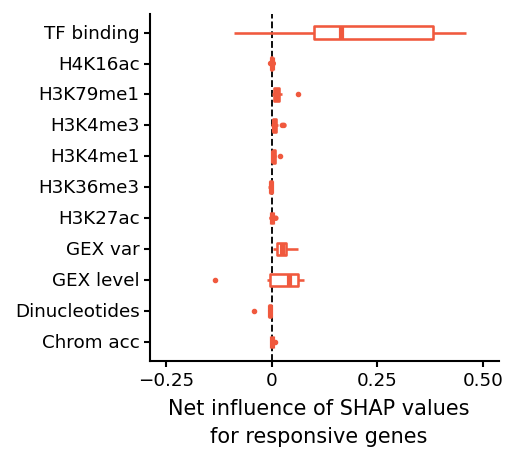

<ggplot: (1401240074402)>

In [20]:
# Plot all models
plot_df = net_inf_df[(net_inf_df['label_name'] == 'Responsive')]
print('All TFs (n={})'.format(len(plot_df['tf'].unique())))

print('Outliers')
display(plot_df[plot_df['shap_diff'] > .5])

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
    + coord_flip()
    + ylim(-.25, .5)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(3, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)

display(ax)

ax.save('figures/Yeast_CallingCards_net_influence.pdf')

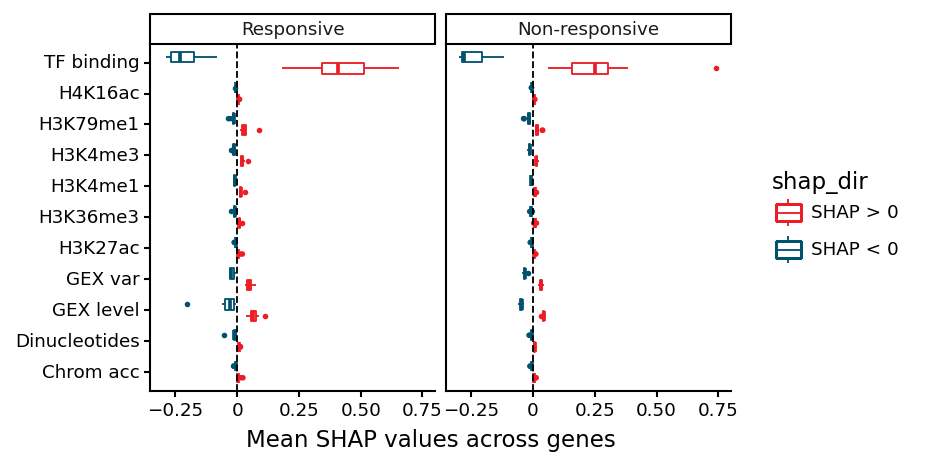

<ggplot: (-9223370635601984070)>

In [36]:
ax = (
    ggplot(sss_df, aes(x='feat_type_name', y='shap', color='shap_dir'))
    + geom_boxplot(alpha=.8, outlier_size=.5)
    + geom_hline(aes(yintercept=0), linetype='dashed')
    + scale_color_manual([COLORS['red'], COLORS['dark_blue']])
    + coord_flip()
    + facet_wrap('label_name')
    + ylim(-.3, .75)
    + labs(x=None, y='Mean SHAP values across genes')
    + theme_classic()
    + theme(
        figure_size=(5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_CallingCards_pos_neg_influence.pdf')

# Feature overall contributions for resp. vs unresp. genes under a yeast TF perturbation

- Left: For a yeast TF, the positive (red) or negative (blue) SHAP values for each feature, summed over genomic positions relative to each gene and averaged over genes that respond to the perturbation of that TF. 
- Right: The same analysis for genes that do not respond to the TF perturbation.

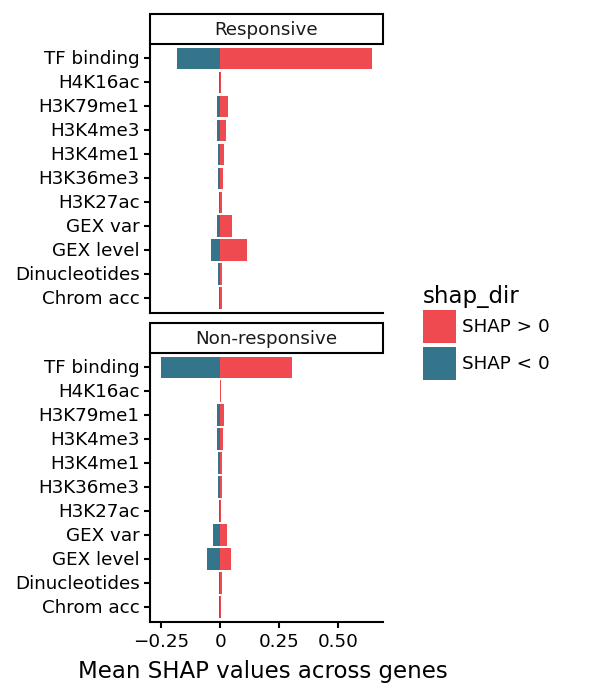

<ggplot: (-9223369054696689927)>

In [6]:
tf_of_interest = 'YNL199C'

ax = (
    ggplot(sss_df[sss_df['tf'] == tf_of_interest], aes(x='feat_type_name', y='shap', fill='shap_dir'))
    + geom_bar(stat='identity', alpha=.8)
    + scale_fill_manual([COLORS['red'], COLORS['dark_blue']])
    + coord_flip()
    + facet_wrap('label_name', ncol=1)
    + labs(x=None, y='Mean SHAP values across genes')
    + theme_classic()
    + theme(
        figure_size=(2, 5), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)

display(ax)

ax.save('figures/Yeast_GCR2_SHAP_resp_v_nonresp_vertical_align.pdf')

# Example of decomposing the predicted score using SHAP values

In [9]:
sys2com_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

pred_df = pd.read_csv(output_dir + 'preds.csv.gz')
pred_df['gene_name'] = pred_df['gene'].apply(lambda x: sys2com_dict[x] if x in sys2com_dict else x)
pred_df = pred_df[pred_df['tf'] == tf_of_interest]

In [10]:
pred_df.sort_values('pred', ascending=False)

,gene,tf,label,pred,tf:gene,gene_name
70302,YGR192C,YNL199C,1,0.645790,YNL199C:YGR192C,TDH3
68353,YBR196C,YNL199C,1,0.625994,YNL199C:YBR196C,PGI1
71116,YJR009C,YNL199C,1,0.614040,YNL199C:YJR009C,TDH2
70632,YHR174W,YNL199C,1,0.612383,YNL199C:YHR174W,ENO2
70348,YGR240C,YNL199C,1,0.589549,YNL199C:YGR240C,PFK1
...,...,...,...,...,...,...
69883,YGL033W,YNL199C,0,0.030764,YNL199C:YGL033W,HOP2
68388,YBR232C,YNL199C,0,0.030713,YNL199C:YBR232C,S000000436
70274,YGR164W,YNL199C,0,0.030675,YNL199C:YGR164W,S000003396
68380,YBR224W,YNL199C,0,0.030511,YNL199C:YBR224W,S000000428


In [11]:
feat_dict = {
    'tf_binding:TF': 'TF binding', 
    'histone_modifications:h3k27ac_tp1_0_merged': 'H3K27ac',
    'histone_modifications:h3k36me3_tp1_0_merged': 'H3K36me3',
    'histone_modifications:h3k4me3_tp1_0_merged': 'H3K4me3',
    'histone_modifications:h3k4me_tp1_0_merged': 'H3K4me1',
    'histone_modifications:h3k79me_tp1_0_merged': 'H3K79me1',
    'histone_modifications:h4k16ac_tp1_0_merged': 'H4K16ac',
    'chromatin_accessibility:BY4741_ypd_osm_0min.occ': 'Chrom acc',
    'gene_expression:TF': 'GEX level', 
    'gene_expression:variation': 'GEX var',
    'dna_sequence:nt_freq_agg': 'Dinucleotides'
}

target_dfs = []
ordered_targets = []
for sys_gene in ['YGR192C', 'YGL033W']:
    target_df = parse_gene_shap_mtx(output_dir, tf=tf_of_interest, gene=sys_gene, width=15)
    gene_name = sys2com_dict[sys_gene]
    target_df['gene_name'] = gene_name
    target_dfs.append(target_df)
    ordered_targets.append(gene_name)

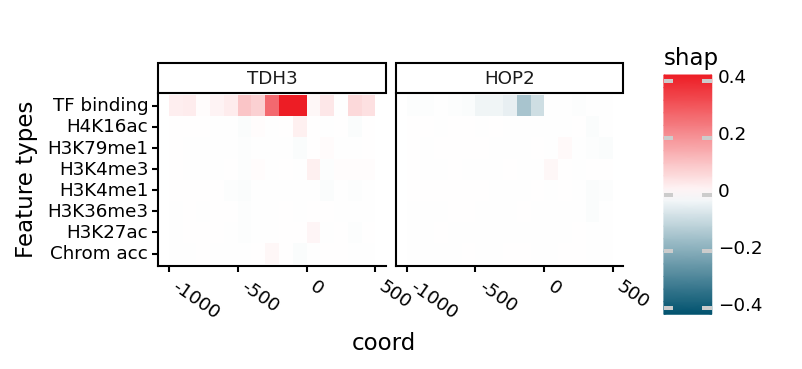

<ggplot: (1432390321977)>

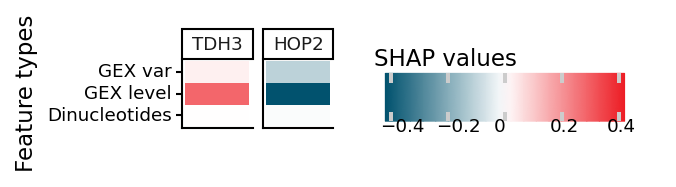

<ggplot: (1432389376120)>

In [14]:
plot_df = pd.concat(target_dfs, ignore_index=True)
plot_df['gene_name'] = pd.Categorical(plot_df['gene_name'], ordered=True, categories=ordered_targets)
plot_df['coord'] = plot_df['pos'] * 100 - 1000
plot_df['feat_type_name'] = plot_df['feat_type_name'].apply(lambda x: feat_dict[x])
plot_feats = sorted(feat_dict.values())

ax = (
    ggplot(plot_df[~plot_df['feat_type_name'].isin(plot_feats[1:4])], aes(x='coord', y='feat_type_name', fill='shap'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=[COLORS['dark_blue'], '#FFFFFF', COLORS['red']], values=[0, 1/2, 1], limits=[-0.4, 0.4])
    + scale_x_continuous(breaks=range(-1050, 551, 500), labels=range(-1000, 501, 500))
    + facet_wrap('gene_name', ncol=2)
    + ylab('Feature types')
    + theme_classic()
    + theme(
        figure_size=(4, 1.5), dpi=150,
        axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_GCR2_coord_dep_shap.pdf')


ax = (
    ggplot(plot_df[plot_df['feat_type_name'].isin(plot_feats[1:4])], aes(x='coord', y='feat_type_name', fill='shap'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=[COLORS['dark_blue'], '#FFFFFF', COLORS['red']], values=[0, 1/2, 1], limits=[-0.4, 0.4],
        name='SHAP values')
    + facet_wrap('gene_name', ncol=2)
    + ylab('Feature types')
    + theme_classic()
    + theme(
        figure_size=(1.3, .6), dpi=150,
        axis_text_x=element_blank(),
        axis_title_x=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_minor_x=element_blank(),
        axis_text_y=element_text(color='#000000'),
        legend_direction='horizontal')
)
display(ax)

ax.save('figures/Yeast_GCR2_coord_indep_shap.pdf')

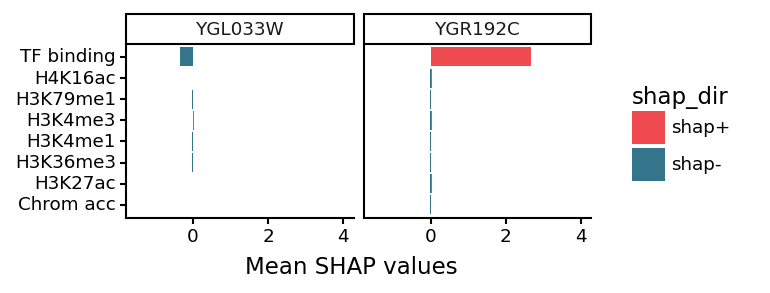

<ggplot: (-9223370604505211893)>

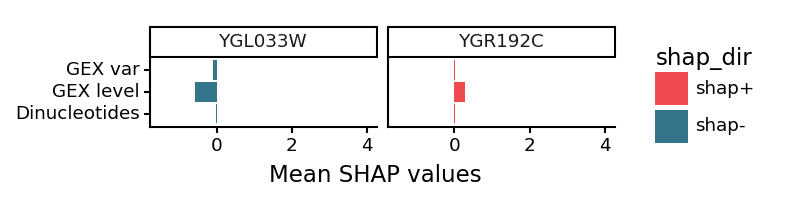

<ggplot: (-9223370604503999470)>

In [16]:
plot_df['shap+'] = [x if x > 0 else 0 for x in plot_df['shap']]
plot_df['shap-'] = [x if x < 0 else 0 for x in plot_df['shap']]

plot_pos = plot_df.groupby(['gene', 'feat_type_name'])['shap+'].sum().reset_index()
plot_pos['shap_dir'] = 'shap+'
plot_pos = plot_pos.rename(columns={'shap+': 'shap'})
plot_neg = plot_df.groupby(['gene', 'feat_type_name'])['shap-'].sum().reset_index()
plot_neg['shap_dir'] = 'shap-'
plot_neg = plot_neg.rename(columns={'shap-': 'shap'})

plot_df2 = pd.concat([plot_pos, plot_neg])

ax = (
    ggplot(plot_df2[~plot_df2['feat_type_name'].isin(plot_feats[1:4])], aes(x='feat_type_name', y='shap', fill='shap_dir'))
    + geom_bar(stat='identity', alpha=.8)
    + scale_fill_manual([COLORS['red'], COLORS['dark_blue']])
    + coord_flip()
    + facet_wrap('gene', ncol=2)
    + ylim(-1.5, 4)
    + labs(x=None, y='Mean SHAP values')
    + theme_classic()
    + theme(
        figure_size=(4, 1.5), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_GCR2_coord_dep_shap_agg.pdf')

ax = (
    ggplot(plot_df2[plot_df2['feat_type_name'].isin(plot_feats[1:4])], aes(x='feat_type_name', y='shap', fill='shap_dir'))
    + geom_bar(stat='identity', alpha=.8)
    + scale_fill_manual([COLORS['red'], COLORS['dark_blue']])
    + coord_flip()
    + facet_wrap('gene', ncol=2)
    + ylim(-1.5, 4)
    + labs(x=None, y='Mean SHAP values')
    + theme_classic()
    + theme(
        figure_size=(4, .6), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_GCR2_coord_indep_shap_agg.pdf')